In [23]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [24]:
data = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
data = np.array(data, dtype = 'int64')
data
data.shape
# print(type(data[0, 0]))

(42000, 785)

In [26]:
X = data[:, 1:]
Y = data[:, 0]
X = np.array(X, dtype = np.float128)
X *= (1 / 255)

In [27]:
import numpy as np


class NeuralNetwork(object):
    def __init__(self, topology, epsilon, numLabels):
        self.theta = []
        self.topology = topology
        self.numLabels = numLabels
        for layer in range(len(self.topology)):
            if layer == 0:
                continue
            self.theta.append(np.random.rand(self.topology[layer], self.topology[layer - 1] + 1) * 2 * epsilon - epsilon)
    
    
    def gradientDescent(self, iters, alpha, lamda, X, Y):
        self.X = X
        self.Y = Y
        for i in range(iters):
            (J, thetaGrad) = self.getCostAndGradient(lamda)
            for layer in range(len(self.topology) - 1):
                self.theta[layer] -= thetaGrad[layer] * alpha
            print("Iter " + str(i) + ": " + str(J))
    
    
    def predict(self, x):
        x = x.reshape((x.shape[0], 1))
        x = np.concatenate(([[1]], x))
        for layer in range(1, len(self.topology)):
            x = np.matmul(self.theta[layer - 1], x)
            for i in range(x.shape[0]):
                x[i, 0] = self.sigmoid(x[i, 0])
            if layer != len(self.topology) - 1:
                x = np.concatenate(([[1]], x))
        
        prediction = -1
        predictionSurety = -1
        for i in range(self.numLabels):
            if x[i, 0] > predictionSurety:
                prediction = i
                predictionSurety = x[i, 0]
        
        return prediction
    
    
    def getCostAndGradient(self, lamda):
        J = 0
        thetaGrad = []
        for layer in range(len(self.topology)):
            if layer == 0:
                continue
            thetaGrad.append(np.zeros((self.topology[layer], self.topology[layer - 1] + 1)))
        
        m = self.X.shape[0]
        for example in range(m):
            x = self.X[example].copy()
            x = x.reshape((x.shape[0], 1))
            y = np.zeros(self.numLabels)
            y[self.Y[example]] = 1
            y = y.reshape((y.shape[0], 1))
            a = []
            z = []
            delta = []
            
            for layer in range(len(self.topology)):
                if layer == 0:
                    a.append(np.concatenate(([[1]], x)))
                    z.append(np.concatenate(([[1]], x)))
                    delta.append(0)
                    continue
                z.append(np.matmul(self.theta[layer - 1], a[layer - 1]))
                a.append(z[layer].copy())
                for i in range(self.topology[layer]):
                    a[layer][i, 0] = self.sigmoid(a[layer][i, 0])
                if layer != len(self.topology) - 1:
                    a[layer] = np.concatenate(([[1]], a[layer]))
                    z[layer] = np.concatenate(([[1]], z[layer]))
                delta.append(0)
                
            for layer in range(len(self.topology) - 1, 0, -1):
                if layer == len(self.topology) - 1:
                    delta[layer] = a[layer] - y
                    thetaGrad[layer - 1] += np.matmul(delta[layer], a[layer - 1].transpose())
                    continue
                
                sigDerZ = z[layer].copy()
                for i in range(self.topology[layer] + 1):
                    sigDerZ[i] = self.sigmoidDerivative(sigDerZ[i])
                
                if layer >= len(self.topology) - 2:
                    delta[layer] = np.matmul(self.theta[layer].transpose(), delta[layer + 1]) * sigDerZ
                else:
                    delta[layer] = np.matmul(self.theta[layer].transpose(), delta[layer + 1][1:, :]) * sigDerZ
                
                thetaGrad[layer - 1] += np.matmul(delta[layer][1:, :], a[layer - 1].transpose())
            
            J += np.sum(-(1 - y) * np.log(1 - a[len(self.topology) - 1])) - np.sum(y * np.log(a[len(self.topology) - 1]))
        
        J /= m
        
        for layer in range(len(self.topology) - 1):
            thetaGrad[layer] *= (1 / m)
        
        for i in range(len(self.topology) - 1):
            for j in range(self.topology[i + 1]):
                for k in range(1, self.topology[i]):
                    J += (lamda / (2 * m)) * self.theta[i][j, k] ** 2
                    thetaGrad[i][j, k] += (lamda / m) * self.theta[i][j, k]
        
        return (J, thetaGrad)
    
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    
    def sigmoidDerivative(self, x):
        sig = self.sigmoid(x)
        return sig * (1 - sig)

In [28]:
epsilon = 0.12
numLabels = 10
digitRecognizer = NeuralNetwork([784, 28, 10], 0.12, numLabels)

In [29]:
lamda = 10
alpha = 0.5
for i in range(0, 4000, 400):
    X_train = X[i:i + 400]
    Y_train = Y[i:i + 400]
    digitRecognizer.gradientDescent(50, alpha, lamda, X_train, Y_train)

Iter 0: 7.693389165219455525
Iter 1: 4.663053791934227005
Iter 2: 4.5469426452242016866
Iter 3: 4.5063388831733089276
Iter 4: 4.4698044540552797194
Iter 5: 4.4345994277252040712
Iter 6: 4.400383559711713924
Iter 7: 4.3670310892773085455
Iter 8: 4.334458179427438938
Iter 9: 4.3025941405506811367
Iter 10: 4.271374488882578881
Iter 11: 4.2407388655260098444
Iter 12: 4.2106302378250329323
Iter 13: 4.1809945151455870024
Iter 14: 4.1517803518467381366
Iter 15: 4.1229390708709319612
Iter 16: 4.0944246817476886375
Iter 17: 4.0661939751882667845
Iter 18: 4.0382066761627507037
Iter 19: 4.010425635481700591
Iter 20: 3.9828170391825961714
Iter 21: 3.9553506165423447459
Iter 22: 3.9279998312667838548
Iter 23: 3.9007420454163312207
Iter 24: 3.8735586505514912098
Iter 25: 3.8464351642228091733
Iter 26: 3.8193612916693281142
Iter 27: 3.7923309524605631638
Iter 28: 3.7653422703100788687
Iter 29: 3.7383975221189185648
Iter 30: 3.7115030402643620867
Iter 31: 3.6846690609939735013
Iter 32: 3.6579095121065

In [30]:
def checkAccuracy(l, r):
    correct = 0
    total = 0
    for i in range(l, r):
        if digitRecognizer.predict(X[i]) == Y[i]:
            correct += 1
        total += 1
    print((correct / total) * 100)

In [31]:
def test(i):
    print(digitRecognizer.predict(X[i]))
    print(Y[i])
    currentImage = X[i].copy()
    currentImage = currentImage.reshape((28, 28)) * 255
    currentImage = np.array(currentImage, dtype = 'float64')
    plt.gray()
    plt.imshow(currentImage, interpolation="nearest")
    plt.show()

In [32]:
def seeResults():
    for i in range(501, 42000):
        test(i)
        input("Enter to continue.")

In [33]:
checkAccuracy(0, 42000)

78.7


9
9


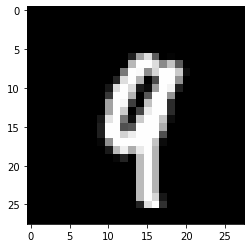

Enter to continue. 


0
0


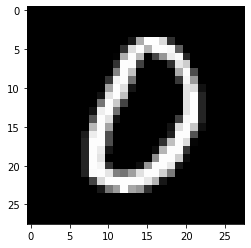

Enter to continue. 


3
5


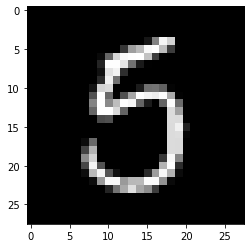

Enter to continue. 


7
7


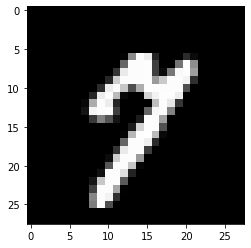

Enter to continue. 


6
6


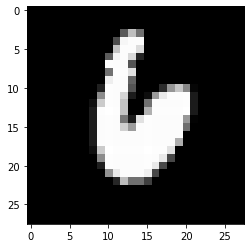

Enter to continue. 


8
8


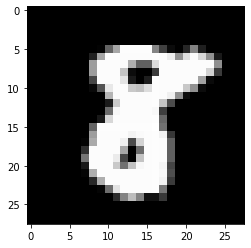

Enter to continue. 


2
2


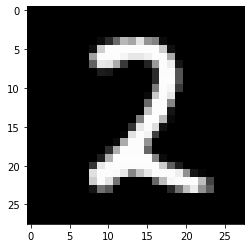

Enter to continue. 


0
0


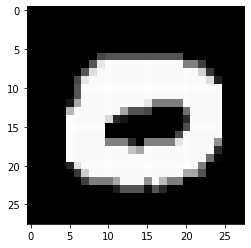

Enter to continue. 


7
7


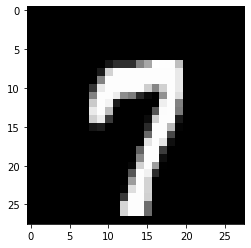

Enter to continue. 


3
3


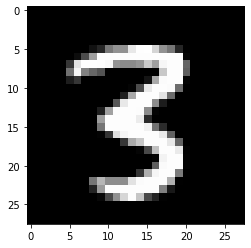

Enter to continue. 


8
5


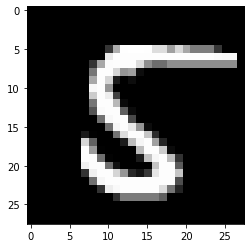

Enter to continue. 


8
8


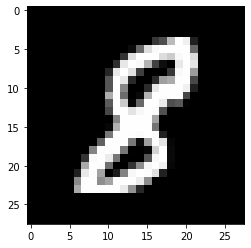

Enter to continue. 


2
2


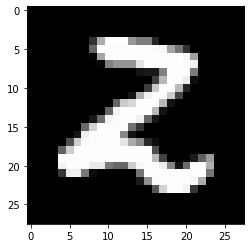

Enter to continue. 


8
8


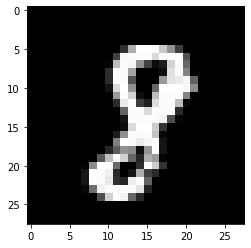

Enter to continue. 


2
2


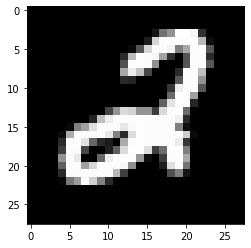

Enter to continue. 


1
4


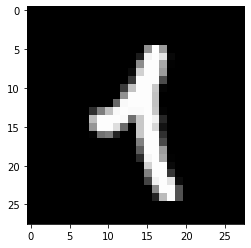

Enter to continue. 


1
8


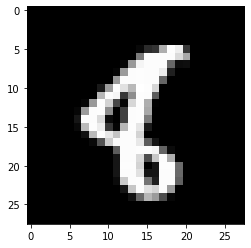

Enter to continue. 


5
5


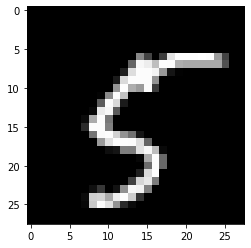

Enter to continue. 


8
8


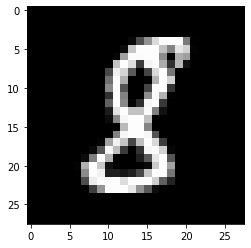

Enter to continue. 


4
9


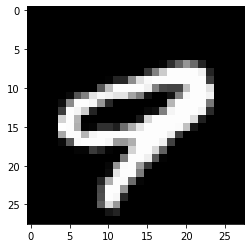

Enter to continue. 


7
7


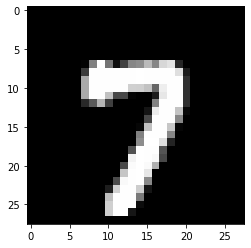

Enter to continue. 


1
1


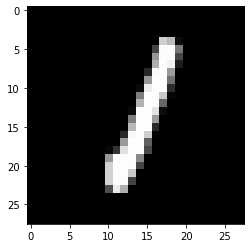

Enter to continue. 


2
2


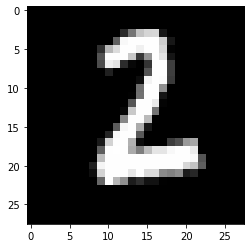

Enter to continue. 


4
4


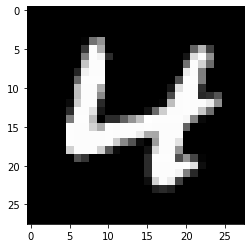

Enter to continue. 


0
5


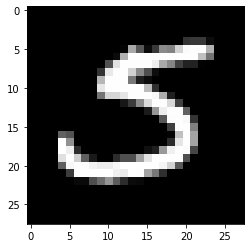

Enter to continue. 


3
5


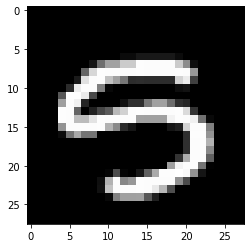

Enter to continue. 


1
1


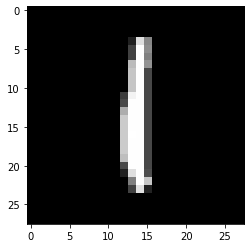

Enter to continue. 


3
8


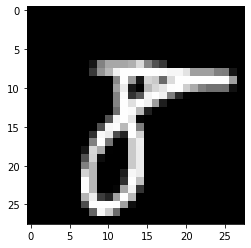

Enter to continue. 


1
1


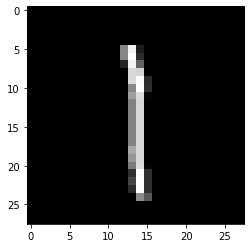

Enter to continue. 


9
4


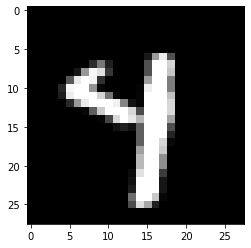

Enter to continue. 


4
4


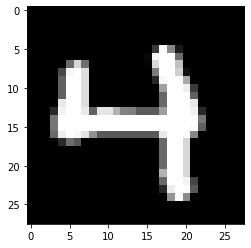

In [ ]:
seeResults()